In [1]:
library(glmnet)
library(ggplot2)
library(dplyr)
library(reshape2)
library(Boruta)
library(survival)
library(broom)
library(rms)

Loading required package: Matrix

Loaded glmnet 4.1-10


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'rms' was built under R version 4.5.2"
Loading required package: Hmisc

Warning message:
"package 'Hmisc' was built under R version 4.5.2"

Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units




In [2]:
df = read.csv("final_imputed_with_sofa_firsticu.csv")
head(df)

,gender,age,red_blood_cells,hemoglobin,rdw,hematocrit,neutrophils,lymphocytes,platelets,alt,⋯,crrt_used,vasoactive_used,weight_admit,survival_time,outcome,survival_30,tibc_quantile_group,ferritin_quantile_group,iron_quantile_group,transferrin_quantile_group
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,75.59,3.00,9.2,17.6,27.2,77.0,14.0,115,7,⋯,0,1,93.0,28,1,0,1,3,3,1
2,0,67.78,3.91,11.3,16.1,35.7,89.3,15.5,525,25,⋯,0,0,70.5,75,1,1,2,2,3,2
3,1,85.47,4.35,13.8,15.5,40.4,39.0,59.0,120,134,⋯,0,1,72.5,1,1,0,2,4,2,2
4,1,67.85,3.67,10.6,16.2,33.3,90.6,2.8,371,33,⋯,0,1,61.9,563,1,1,2,4,4,2
5,1,60.83,2.60,8.7,24.1,25.6,93.2,96.0,46,109,⋯,0,0,100.8,22,1,0,3,4,4,3
6,1,74.45,2.88,9.4,27.5,27.5,90.5,8.1,208,30,⋯,0,0,64.7,11,1,0,1,4,1,1


In [3]:
data <- df %>% select(-c(transferrin_quantile_group, survival_30))

In [4]:
# 加载包
library(rms)
library(survival)

# 设定数据环境（这步对rms包很重要）
ddist <- datadist(data) 
options(datadist = 'ddist')


# 确定节点位置：使用四分位百分位数（25%，50%，75%）
knots <- quantile(data$tibc, probs = c(0.05, 0.35, 0.65, 0.95))

# 构建Cox模型
# 注意：rcs(tibc, knots) 表示对tibc进行RCS变换
cox_model <- cph(Surv(survival_time, outcome) ~
                rcs(tibc, knots) + # 这是你关心的核心变量，用RCS拟合
                ferritin + iron + 
                age + gender + sepsis + aki + heart_failure +
                albumin + sodium + lactate + lymphocytes,
                data = data, x=TRUE, y=TRUE)

# 打印模型摘要
cox_model

Cox Proportional Hazards Model

cph(formula = Surv(survival_time, outcome) ~ rcs(tibc, knots) + 
    ferritin + iron + age + gender + sepsis + aki + heart_failure + 
    albumin + sodium + lactate + lymphocytes, data = data, x = TRUE, 
    y = TRUE)

                        Model Tests      Discrimination    
                                                Indexes    
Obs       1128    LR chi2    152.43      R2       0.126    
Events     809    d.f.           14    R2(14,1128)0.115    
Center -2.8665    Pr(> chi2) 0.0000     R2(14,809)0.157    
                  Score chi2 162.89      Dxy      0.303    
                  Pr(> chi2) 0.0000                        

              Coef    S.E.   Wald Z Pr(>|Z|)
tibc          -0.0047 0.0022 -2.13  0.0328  
tibc'          0.0006 0.0089  0.07  0.9433  
tibc''         0.0106 0.0250  0.43  0.6706  
ferritin       0.0000 0.0000  0.76  0.4449  
iron           0.0015 0.0008  1.86  0.0629  
age            0.0109 0.0033  3.31  0.0009  
gender       

In [5]:
anova_results <- anova(cox_model)
print(anova_results)
# 方法2：将 anova 结果转换为数据框后提取
anova_df <- as.data.frame(anova_results)
tibc_p <- anova_df["tibc", "P"]
nonlinear_p <- anova_df[" Nonlinear", "P"]

cat("tibc 的 p 值:", tibc_p, "\n")
cat("Nonlinear 的 p 值:", nonlinear_p, "\n")


                Wald Statistics          Response: Surv(survival_time, outcome) 

 Factor        Chi-Square d.f. P     
 tibc           24.28      3   <.0001
  Nonlinear     12.22      2   0.0022
 ferritin        0.58      1   0.4449
 iron            3.46      1   0.0629
 age            10.97      1   0.0009
 gender          0.11      1   0.7389
 sepsis          0.25      1   0.6136
 aki            17.11      1   <.0001
 heart_failure   2.31      1   0.1290
 albumin        10.85      1   0.0010
 sodium          5.05      1   0.0246
 lactate        37.12      1   <.0001
 lymphocytes    15.15      1   0.0001
 TOTAL         160.38     14   <.0001
tibc 的 p 值: 2.180225e-05 
Nonlinear 的 p 值: 0.002215526 


Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"


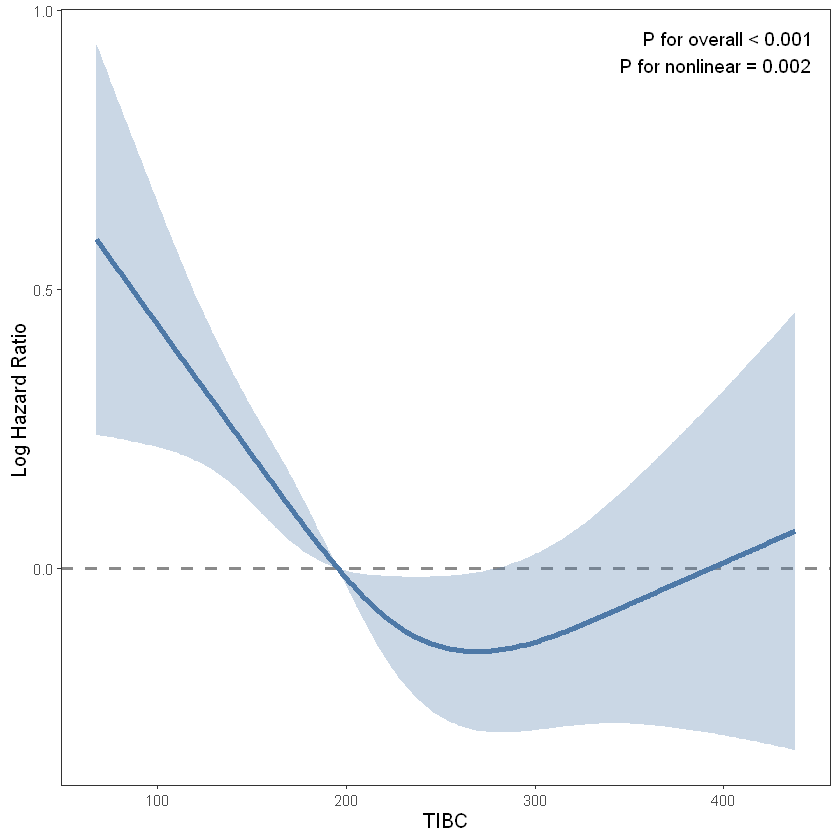

In [6]:
# 获取预测数据
pred_data <- Predict(cox_model, tibc, ref.zero = TRUE)
pred_df <- data.frame(tibc = pred_data$tibc, 
                      yhat = pred_data$yhat,
                      lower = pred_data$lower,
                      upper = pred_data$upper)

# 格式化p值（保留3位小数，科学计数法）
format_pval <- function(p) {
  if (p < 0.001) {
    return("< 0.001")
  } else {
    return(sprintf("= %.3f", p))
  }
}

# 绘制图表
ggplot(pred_df, aes(x = tibc, y = yhat)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#8A8A8A", linewidth = 1) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.3, fill = "#4E79A7") +
  geom_line(color = "#4E79A7", linewidth = 1.5) +
  labs(x = "TIBC", 
       y = "Log Hazard Ratio ") +
  annotate("text", 
           x = Inf, y = Inf,
           label = paste0("P for overall ", format_pval(tibc_p), "\n",
                         "P for nonlinear ", format_pval(nonlinear_p)),
           hjust = 1.1, vjust = 1.5,
           size = 4,
           color = "black") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 12),
        axis.title = element_text(size = 12),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
ggsave("results/plot4.png", dpi = 300, type = "cairo", width = 8, height = 6)

In [7]:
# 加载包
library(rms)
library(survival)

# 设定数据环境（这步对rms包很重要）
ddist <- datadist(data) 
options(datadist = 'ddist')


# 确定节点位置：使用四分位百分位数（25%，50%，75%）
knots <- quantile(data$ferritin, probs = c(0.05, 0.35, 0.5, 0.65, 0.95))

# 构建Cox模型
# 注意：rcs(tibc, knots) 表示对tibc进行RCS变换
cox_model <- cph(Surv(survival_time, outcome) ~
                rcs(ferritin, knots) + # 这是你关心的核心变量，用RCS拟合
                iron + tibc + 
                age + gender + sepsis + aki + heart_failure +
                albumin + sodium + lactate + lymphocytes,
                data = data, x=TRUE, y=TRUE)

# 打印模型摘要
cox_model

Cox Proportional Hazards Model

cph(formula = Surv(survival_time, outcome) ~ rcs(ferritin, knots) + 
    iron + tibc + age + gender + sepsis + aki + heart_failure + 
    albumin + sodium + lactate + lymphocytes, data = data, x = TRUE, 
    y = TRUE)

                        Model Tests      Discrimination    
                                                Indexes    
Obs       1128    LR chi2    169.79      R2       0.140    
Events     809    d.f.           15    R2(15,1128)0.128    
Center -2.1792    Pr(> chi2) 0.0000     R2(15,809)0.174    
                  Score chi2 176.15      Dxy      0.321    
                  Pr(> chi2) 0.0000                        

              Coef    S.E.   Wald Z Pr(>|Z|)
ferritin       0.0007 0.0008  0.87  0.3823  
ferritin'     -0.0574 0.0923 -0.62  0.5338  
ferritin''     0.1654 0.2502  0.66  0.5085  
ferritin'''   -0.1346 0.1895 -0.71  0.4776  
iron           0.0003 0.0009  0.35  0.7278  
tibc          -0.0008 0.0007 -1.22  0.2235  
age          

In [8]:
anova_results <- anova(cox_model)
print(anova_results)
# 方法2：将 anova 结果转换为数据框后提取
anova_df <- as.data.frame(anova_results)
ferritin_p <- anova_df["ferritin", "P"]
nonlinear_p <- anova_df[" Nonlinear", "P"]

cat("ferritin 的 p 值:", ferritin_p, "\n")
cat("Nonlinear 的 p 值:", nonlinear_p, "\n")


                Wald Statistics          Response: Surv(survival_time, outcome) 

 Factor        Chi-Square d.f. P     
 ferritin       29.84      4   <.0001
  Nonlinear     28.94      3   <.0001
 iron            0.12      1   0.7278
 tibc            1.48      1   0.2235
 age            10.69      1   0.0011
 gender          1.00      1   0.3173
 sepsis          1.36      1   0.2431
 aki            19.91      1   <.0001
 heart_failure   2.61      1   0.1064
 albumin        12.53      1   0.0004
 sodium          5.31      1   0.0212
 lactate        33.05      1   <.0001
 lymphocytes    24.21      1   <.0001
 TOTAL         174.60     15   <.0001
ferritin 的 p 值: 5.280246e-06 
Nonlinear 的 p 值: 2.303182e-06 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"


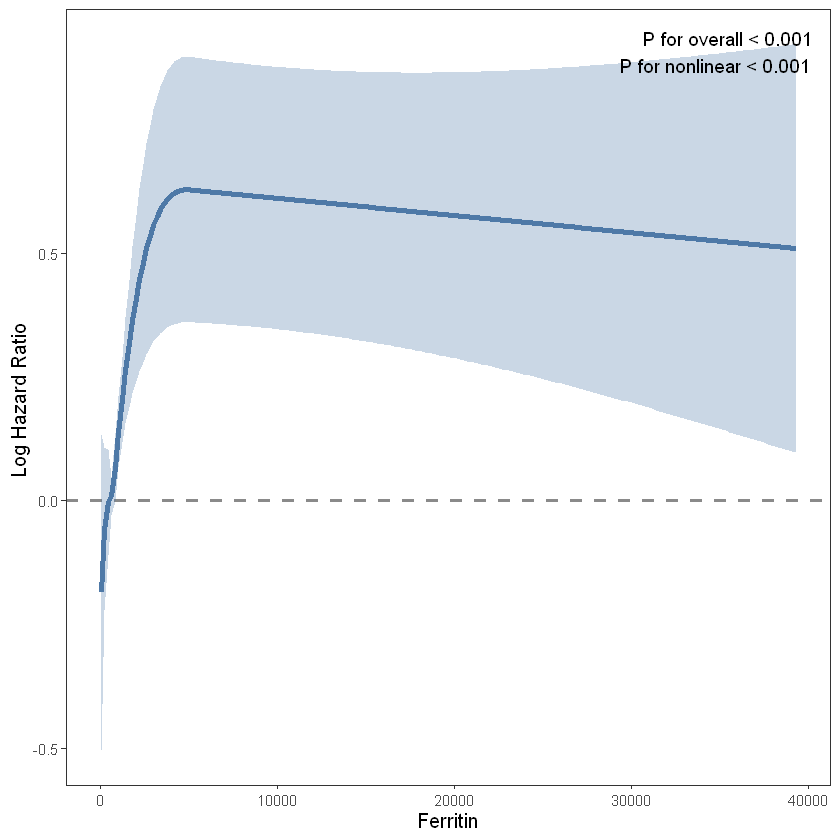

In [9]:
# 获取预测数据
pred_data <- Predict(cox_model, ferritin, ref.zero = TRUE)
pred_df <- data.frame(ferritin = pred_data$ferritin, 
                      yhat = pred_data$yhat,
                      lower = pred_data$lower,
                      upper = pred_data$upper)

format_pval <- function(p) {
  if (p < 0.001) {
    return("< 0.001")
  } else {
    return(sprintf("= %.3f", p))
  }
}

# 绘制图表
ggplot(pred_df, aes(x = ferritin, y = yhat)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#8A8A8A", size = 1) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.3, fill = "#4E79A7") +
  geom_line(color = "#4E79A7", size = 1.5) +
  labs(x = "Ferritin", 
       y = "Log Hazard Ratio ") +
  annotate("text", 
           x = Inf, y = Inf,
           label = paste0("P for overall ", format_pval(ferritin_p), "\n",
                         "P for nonlinear ", format_pval(nonlinear_p)),
           hjust = 1.1, vjust = 1.5,
           size = 4,
           color = "black") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 12),
        axis.title = element_text(size = 12),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
ggsave("results/plot5.png", dpi = 300, type = "cairo",width = 8, height = 6)

In [10]:
# 加载包
library(rms)
library(survival)

# 设定数据环境（这步对rms包很重要）
ddist <- datadist(data) 
options(datadist = 'ddist')


# 确定节点位置：使用四分位百分位数（25%，50%，75%）
knots <- quantile(data$iron, probs = c(0.05, 0.35, 0.5, 0.65, 0.95))

# 构建Cox模型
# 注意：rcs(tibc, knots) 表示对tibc进行RCS变换
cox_model <- cph(Surv(survival_time, outcome) ~
                rcs(iron, knots) + # 这是你关心的核心变量，用RCS拟合
                ferritin + tibc + 
                age + gender + sepsis + aki + heart_failure +
                albumin + sodium + lactate + lymphocytes,
                data = data, x=TRUE, y=TRUE)

# 打印模型摘要
cox_model

Cox Proportional Hazards Model

cph(formula = Surv(survival_time, outcome) ~ rcs(iron, knots) + 
    ferritin + tibc + age + gender + sepsis + aki + heart_failure + 
    albumin + sodium + lactate + lymphocytes, data = data, x = TRUE, 
    y = TRUE)

                        Model Tests      Discrimination    
                                                Indexes    
Obs       1128    LR chi2    146.82      R2       0.122    
Events     809    d.f.           15    R2(15,1128)0.110    
Center -2.2645    Pr(> chi2) 0.0000     R2(15,809)0.150    
                  Score chi2 152.08      Dxy      0.302    
                  Pr(> chi2) 0.0000                        

              Coef    S.E.   Wald Z Pr(>|Z|)
iron           0.0111 0.0124  0.89  0.3722  
iron'         -0.8136 0.5407 -1.50  0.1324  
iron''         3.5990 2.0727  1.74  0.0825  
iron'''       -3.7855 1.9950 -1.90  0.0578  
ferritin       0.0000 0.0000  1.05  0.2938  
tibc          -0.0020 0.0006 -3.30  0.0010  
age          

In [11]:
anova_results <- anova(cox_model)
print(anova_results)
# 方法2：将 anova 结果转换为数据框后提取
anova_df <- as.data.frame(anova_results)
iron_p <- anova_df["iron", "P"]
nonlinear_p <- anova_df[" Nonlinear", "P"]

cat("iron 的 p 值:", iron_p, "\n")
cat("Nonlinear 的 p 值:", nonlinear_p, "\n")




    

                Wald Statistics          Response: Surv(survival_time, outcome) 

 Factor        Chi-Square d.f. P     
 iron            8.54      4   0.0735
  Nonlinear      5.19      3   0.1581
 ferritin        1.10      1   0.2938
 tibc           10.89      1   0.0010
 age             8.50      1   0.0036
 gender          0.33      1   0.5643
 sepsis          0.17      1   0.6798
 aki            18.66      1   <.0001
 heart_failure   2.04      1   0.1528
 albumin        13.17      1   0.0003
 sodium          3.94      1   0.0471
 lactate        34.76      1   <.0001
 lymphocytes    18.09      1   <.0001
 TOTAL         150.64     15   <.0001
iron 的 p 值: 0.07354489 
Nonlinear 的 p 值: 0.1581158 


Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"


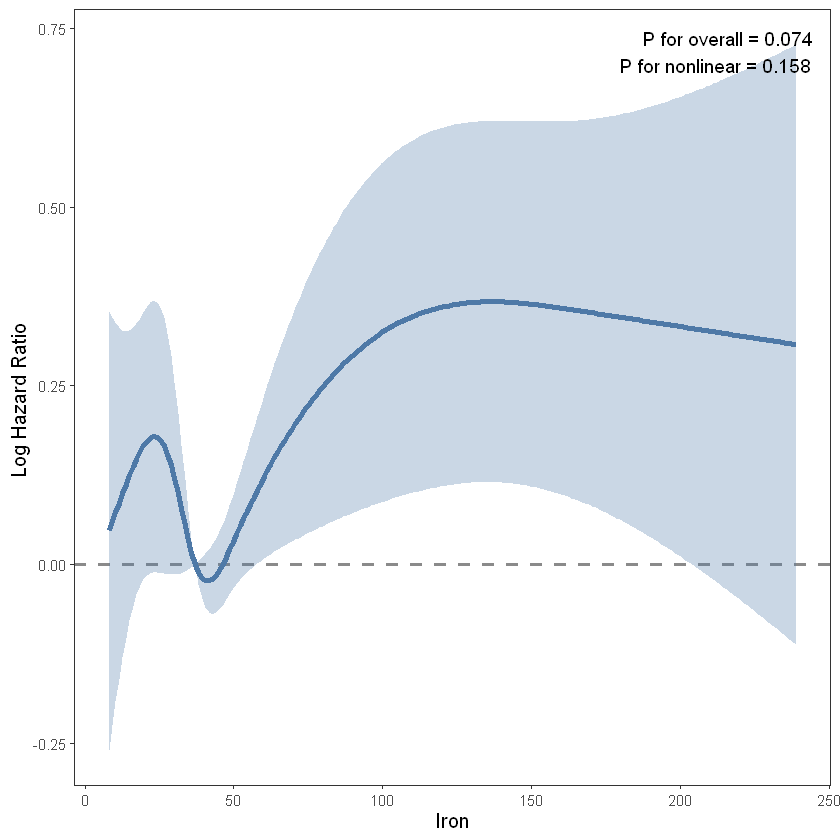

In [12]:
# 获取预测数据
pred_data <- Predict(cox_model, iron, ref.zero = TRUE)
pred_df <- data.frame(iron = pred_data$iron, 
                      yhat = pred_data$yhat,
                      lower = pred_data$lower,
                      upper = pred_data$upper)

format_pval <- function(p) {
  if (p < 0.001) {
    return("< 0.001")
  } else {
    return(sprintf("= %.3f", p))
  }
}

# 绘制图表
ggplot(pred_df, aes(x = iron, y = yhat)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#8A8A8A", size = 1) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.3, fill = "#4E79A7") +
  geom_line(color = "#4E79A7", size = 1.5) +
  labs(x = "Iron", 
       y = "Log Hazard Ratio ") +
  annotate("text", 
           x = Inf, y = Inf,
           label = paste0("P for overall ", format_pval(iron_p), "\n",
                         "P for nonlinear ", format_pval(nonlinear_p)),
           hjust = 1.1, vjust = 1.5,
           size = 4,
           color = "black") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5, size = 12),
        axis.title = element_text(size = 12),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())
ggsave("results/plot6.png", dpi = 300, type = "cairo",width = 8, height = 6)